In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle

from matplotlib.gridspec import GridSpec
from llm_deliberation.utils import bootstrap_statistic_df, jaccard, change_of_minds
from scipy.stats import mannwhitneyu

from pyprojroot import here
from mpl_lego.labels import bold_text, add_significance_bracket_inplot, apply_subplot_labels
from mpl_lego.style import use_latex_style

In [2]:
verdict_ordering = ['NTA', 'YTA', 'NAH', 'ESH']

In [3]:
use_latex_style()

In [5]:
with open(here('data/analysis/exp1_sync_h2h.pkl'), 'rb') as file:
    exp1 = pickle.load(file)

with open(here('data/analysis/exp5_sync_h2h.pkl'), 'rb') as file:
    exp2 = pickle.load(file)

with open(here('data/analysis/exp6_sync_h2h.pkl'), 'rb') as file:
    exp3 = pickle.load(file)

In [7]:
with open(here('data/analysis/exp8_sync_h2h.pkl'), 'rb') as file:
    gpt = pickle.load(file)

with open(here('data/analysis/exp7_sync_h2h.pkl'), 'rb') as file:
    claude = pickle.load(file)

with open(here('data/analysis/exp9_sync_h2h.pkl'), 'rb') as file:
    gemini = pickle.load(file)

In [8]:
def first_round_verdicts(exp, agent):
    return exp[f'Agent_{agent}_verdicts'].apply(lambda x: x[0])

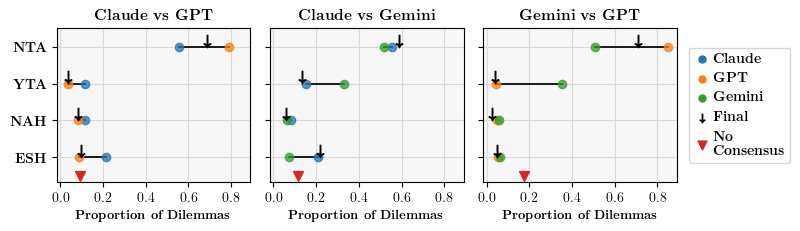

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2), sharey=True, sharex=True)
plt.subplots_adjust(wspace=0.1)

SHIFT = 0.165
axes[0].plot(
    first_round_verdicts(exp1, 1).value_counts(normalize=True)[verdict_ordering],
    [5, 4, 3, 2],
    'o',
    color='C0',
    alpha=0.75)
axes[0].plot(
    first_round_verdicts(exp1, 2).value_counts(normalize=True)[verdict_ordering],
    [5, 4, 3, 2],
    'o',
    color='C1',
    alpha=0.75)
axes[0].scatter(
    exp1['final_verdict'].value_counts(normalize=True, dropna=False)[verdict_ordering],
    np.array([5, 4, 3, 2]) + SHIFT,
    color='black',
    marker='$\downarrow$',
    zorder=1000,
    s=80)

# Example for exp1 (Claude vs GPT)
y_levels = [5, 4, 3, 2]
x1 = first_round_verdicts(exp1, 1).value_counts(normalize=True)[verdict_ordering]
x2 = first_round_verdicts(exp1, 2).value_counts(normalize=True)[verdict_ordering]

for y, a, b in zip(y_levels, x1, x2):
    axes[0].plot([a, b], [y, y], color='black', lw=1.25, zorder=1)

axes[1].plot(
    first_round_verdicts(exp2, 1).value_counts(normalize=True)[verdict_ordering],
    [5, 4, 3, 2],
    'o',
    color='C0',
    alpha=0.75)
axes[1].plot(
    first_round_verdicts(exp2, 2).value_counts(normalize=True)[verdict_ordering],
    [5, 4, 3, 2],
    'o',
    color='C2',
    alpha=0.75)
axes[1].scatter(
    exp2['final_verdict'].value_counts(normalize=True, dropna=True)[verdict_ordering],
    np.array([5, 4, 3, 2]) + SHIFT,
    color='black',
    marker='$\downarrow$',
    zorder=1000,
    s=80)

# Example for exp1 (Claude vs GPT)
y_levels = [5, 4, 3, 2]
x1 = first_round_verdicts(exp2, 1).value_counts(normalize=True)[verdict_ordering]
x2 = first_round_verdicts(exp2, 2).value_counts(normalize=True)[verdict_ordering]

for y, a, b in zip(y_levels, x1, x2):
    axes[1].plot([a, b], [y, y], color='black', lw=1.25, zorder=1)

axes[2].plot(
    first_round_verdicts(exp3, 1).value_counts(normalize=True)[verdict_ordering],
    [5, 4, 3, 2],
    'o',
    color='C1',
    alpha=0.75)
axes[2].plot(
    first_round_verdicts(exp3, 2).value_counts(normalize=True)[verdict_ordering],
    [5, 4, 3, 2],
    'o',
    color='C2',
    alpha=0.75)
axes[2].scatter(
    exp3['final_verdict'].value_counts(normalize=True, dropna=False)[verdict_ordering],
    np.array([5, 4, 3, 2]) + SHIFT,
    color='black',
    marker='$\downarrow$',
    zorder=1000,
    s=80)

# Example for exp1 (Claude vs GPT)
y_levels = [5, 4, 3, 2]
x1 = first_round_verdicts(exp3, 1).value_counts(normalize=True)[verdict_ordering]
x2 = first_round_verdicts(exp3, 2).value_counts(normalize=True)[verdict_ordering]

for y, a, b in zip(y_levels, x1, x2):
    axes[2].plot([a, b], [y, y], color='black', lw=1.25, zorder=1)

# plot no-consensus slightly below the last verdict row
for idx, exp in enumerate([exp1, exp2, exp3]):
    nc = exp['final_verdict'].isna().mean()
    axes[idx].scatter(
        [nc],
        [1.5],   # just below ESH’s y=2
        color='C3',
    marker='v',   # diamond marker
    s=50,
    zorder=1000)

for ax in axes:
    ax.grid(True, color='0.85', linewidth=0.8)
    ax.set_axisbelow(True)
    ax.set_yticks([2, 3, 4, 5])
    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(top=5.5)
    ax.set_facecolor(color='0.97')
    ax.set_xlabel(bold_text('Proportion of Dilemmas'), fontsize=9)
axes[0].set_yticklabels(bold_text(list(reversed(verdict_ordering))))

axes[2].scatter([], [], color='C0', s=25, label=bold_text('Claude'))
axes[2].scatter([], [], color='C1', s=25, label=bold_text('GPT'))
axes[2].scatter([], [], color='C2', s=25, label=bold_text('Gemini'))
axes[2].scatter([], [], color='black', marker='$\downarrow$', s=40,
                label=bold_text('Final'))
axes[2].scatter([], [], color='C3', marker='v', s=40,
                label=bold_text('No\nConsensus'))

axes[2].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    handlelength=1.,
    handletextpad=0.3,
    borderaxespad=0.2,
    labelspacing=0.5
)

axes[0].set_title(bold_text('Claude vs GPT'), fontsize=11)
axes[1].set_title(bold_text('Claude vs Gemini'), fontsize=11)
axes[2].set_title(bold_text('Gemini vs GPT'), fontsize=11)

plt.savefig('figure_verdicts.pdf', bbox_inches='tight')